In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import io

# import seaborn as sns

# Extraction des Données

In [2]:
# Chemin vers le fichier Excel
file_path = 'Online Retail.xlsx'
# Chargement du fichier Excel dans un DataFrame
with io.open(file_path, 'r', encoding='utf-8') as f:
    try:
        df = pd.read_excel(file_path, engine='openpyxl')
        # Affichez les premières lignes pour vérifier si le chargement s'est bien déroulé
        print(df.head())
    except Exception as e:
        print(f"Erreur lors de la lecture du fichier Excel : {e}")

# Affichage des premières lignes du DataFrame
#print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


### Nettoyage des données
soustraction des valeurs négatives de la colonne Quantity

In [3]:
positive_quantities = df[df['Quantity'] >= 0]
positive_quantities['InvoiceDate'] = pd.to_datetime(
    positive_quantities['InvoiceDate'])

positive_quantities.to_csv('positive_quantities.csv', index=False)

C:\Users\steph\AppData\Local\Temp\ipykernel_9436\2312504916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_quantities['InvoiceDate'] = pd.to_datetime(


# Transformation des données
Création d'un nouveau dataframe issus de regroupement par client avec la récence, la somme des dépenses par client et la fréquence d'achat par client en fonction de la date de référence.

In [4]:
# Calcul de la récence, fréquence et montant
reference_date = pd.to_datetime('2010-12-01')
rfm = positive_quantities.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'CustomerID': 'count',
    'UnitPrice': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'CustomerID': 'Frequency',
    'UnitPrice': 'Monetary'
}).reset_index()



### Utilisation du machine learning pour segmenter les clients (k-mean)

Exception in thread Thread-5 (_readerthread):
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in pos

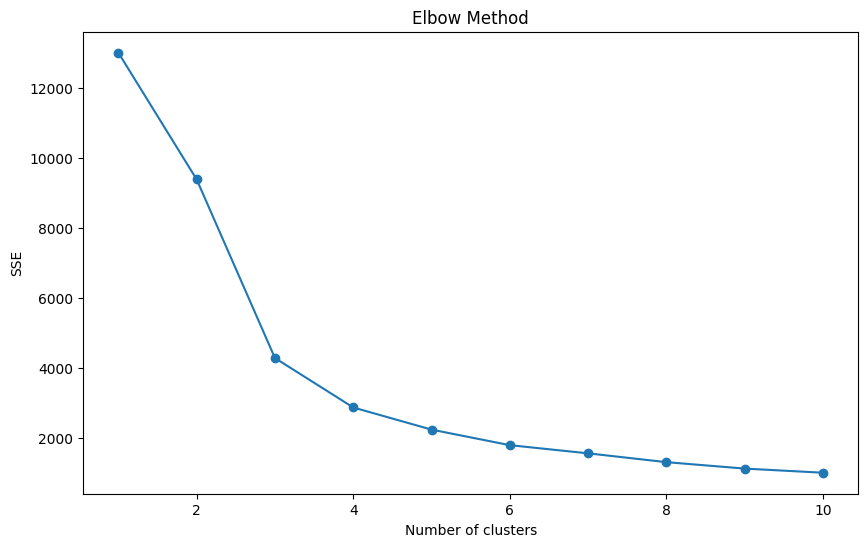

In [5]:
# Préparer les données pour le clustering
rfm_data = rfm[['Recency', 'Frequency', 'Monetary']]


# Standardiser les données

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

# Déterminer le nombre optimal de clusters avec la méthode du coude

sse = []

for k in range(1, 11):

    kmeans = KMeans(n_clusters=k, random_state=42)

    kmeans.fit(rfm_scaled)

    sse.append(kmeans.inertia_)


# Visualiser la méthode du coude

plt.figure(figsize=(10, 6))

plt.plot(range(1, 11), sse, marker='o')

plt.xlabel('Number of clusters')

plt.ylabel('SSE')

plt.title('Elbow Method')

plt.show()

In [6]:
# Appliquer K-means avec le nombre optimal de clusters 
optimal_clusters = 4
# Initialiser K-means
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
# Prédire les clusters
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Mapper les numéros de clusters aux noms significatifs
cluster_names = {
    0: 'Champions',
    1: 'Clients Fidèles',
    2: 'Grands Dépenseurs',
    3: 'Clients Potentiels'
}

# Appliquer le mapping des noms aux clusters
rfm['Cluster Name'] = rfm['Cluster'].map(cluster_names)

print(rfm.head())
# Exporter les données
rfm.to_csv('rfm_online_retail.csv', index=False)
# Analyser les clusters
cluster_aggregates = rfm.groupby('Cluster Name').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).reset_index()
# Afficher les résultats de l'analyse des clusters
print(cluster_aggregates)

# Exporter les résultats de l'analyse des clusters
cluster_aggregates.to_csv('cluster_aggregates_online_retail.csv', index=False)


# # Visualiser les clusters
# plt.figure(figsize=(10, 6))

# # Définir les couleurs pour les clusters
# colors = ['blue', 'green', 'red', 'purple']

# # Tracer chaque cluster
# for cluster_num, color in zip(cluster_names.keys(), colors):
#     cluster_data = rfm[rfm['Cluster'] == cluster_num]
#     plt.scatter(cluster_data['Recency'], cluster_data['Monetary'],
#                 color=color, s=100, label=cluster_names[cluster_num])

# # Ajouter des labels et une légende
# plt.title('RFM Clustering')
# plt.xlabel('Recency')
# plt.ylabel('Monetary')
# plt.legend()
# plt.grid(True)
# plt.show()

   CustomerID  Recency  Frequency  Monetary  Cluster     Cluster Name
0     12346.0      -49          1      1.04        1  Clients Fidèles
1     12347.0     -372        182    481.21        0        Champions
2     12348.0     -299         31    178.71        0        Champions
3     12349.0     -356         73    605.10        0        Champions
4     12350.0      -64         17     65.30        1  Clients Fidèles
         Cluster Name     Recency    Frequency      Monetary
0           Champions -330.631838    74.233868    221.449726
1     Clients Fidèles -125.223585    27.607547     96.468463
2  Clients Potentiels -359.333333   535.103604   1667.053018
3   Grands Dépenseurs -372.500000  5807.750000  22893.065000


In [7]:
cluster_aggregates = cluster_aggregates.sort_values(
    by='Monetary', ascending=False)
print(cluster_aggregates)

         Cluster Name     Recency    Frequency      Monetary
3   Grands Dépenseurs -372.500000  5807.750000  22893.065000
2  Clients Potentiels -359.333333   535.103604   1667.053018
0           Champions -330.631838    74.233868    221.449726
1     Clients Fidèles -125.223585    27.607547     96.468463
